In [ ]:
# default_exp data.validation

# Data Validation

> Functions required to perform cross-validation.

In [ ]:
#export
from tsai.imports import *
from tsai.utils import *

In [ ]:
#export
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from imblearn.over_sampling import RandomOverSampler

In [ ]:
#export
def check_overlap(a, b):
    a = toarray(a)
    b = toarray(b)
    overlap = np.isin(a, b)
    if isinstance(overlap[0], (list, L, np.ndarray, torch.Tensor)):  overlap = overlap[0] 
    if not any(overlap): return False
    else: return a[overlap]


def leakage_finder(*splits, verbose=True):
    '''You can pass splits as a tuple, or train, valid, ...'''
    splits = L(*splits)
    overlaps = 0
    for i in range(len(splits)):
        for j in range(i + 1, len(splits)):
            overlap = check_overlap(splits[i], splits[j])
            if overlap: 
                pv(f'overlap between splits [{i}, {j}] {overlap}', verbose)
                overlaps += 1
    assert overlaps == 0, 'Please, review your splits!'


def balance_idx(o, shuffle=False, random_state=None, verbose=False):
    if isinstance(o, list): o = L(o)
    idx_ = np.arange(len(o)).reshape(-1, 1)
    ros = RandomOverSampler(random_state=random_state)
    resampled_idxs, _ = ros.fit_resample(idx_, np.asarray(o))
    new_idx = L(resampled_idxs.reshape(-1,).tolist())
    if shuffle: new_idx = random_shuffle(new_idx)
    return new_idx

In [ ]:
a = np.arange(10)
b = np.arange(10, 20)
test_eq(check_overlap(a, b), False)
a = np.arange(10)
b = np.arange(9, 20)
test_eq(check_overlap(a, b), [9])

In [ ]:
l = L(list(concat(np.zeros(5), np.ones(10)).astype(int)))
balanced_idx = balance_idx(l)
test_eq(np.mean(l[balanced_idx]), 0.5)
test_eq(isinstance(balanced_idx, L), True)

l = list(concat(np.zeros(5), np.ones(10)).astype(int))
balanced_idx = balance_idx(l)
test_eq(np.mean(L(l)[balanced_idx]), 0.5)
test_eq(isinstance(balanced_idx, L), True)

a = concat(np.zeros(5), np.ones(10)).astype(int)
balanced_idx = balance_idx(a)
test_eq(np.mean(a[balanced_idx]), 0.5)
test_eq(isinstance(balanced_idx, L), True)

t = concat(torch.zeros(5), torch.ones(10))
balanced_idx = balance_idx(t, shuffle=True)
test_eq(t[balanced_idx].mean(), 0.5)
test_eq(isinstance(balanced_idx, L), True)

In [ ]:
a, b = np.arange(100_000), np.arange(100_000, 200_000)

In [ ]:
soft_labels = True
filter_pseudolabels = .5
balanced_pseudolabels = True


pseudolabels = torch.rand(1000, 3)
pseudolabels = torch.softmax(pseudolabels, -1) if soft_labels else torch.argmax(pseudolabels, -1)
hpl = torch.argmax(pseudolabels, -1) if soft_labels else pseudolabels

if filter_pseudolabels and pseudolabels.ndim > 1: 
    error = 1 - pseudolabels.max(-1).values
    filt_pl_idx = np.arange(len(error))[error < filter_pseudolabels]
    filt_pl = pseudolabels[error < filter_pseudolabels]
    assert len(filt_pl) > 0, 'no filtered pseudolabels'
    filt_hpl = torch.argmax(filt_pl, -1)
else: 
    filt_pl_idx = np.arange(len(pseudolabels))
    filt_pl = filt_hpl = pseudolabels
pl_split = filt_pl_idx[balance_idx(filt_hpl)] if balanced_pseudolabels else filt_pl_idx
test_eq(hpl[pl_split].float().mean(), np.mean(np.unique(hpl)))

In [ ]:
#export
def TrainValidTestSplitter(n_splits:int=1, valid_size:Union[float, int]=0.2, test_size:Union[float, int]=0., train_only:bool=False,
                           stratify:bool=True, balance:bool=False, shuffle:bool=True, random_state:Union[None, int]=None, verbose:bool=False, **kwargs):
    "Split `items` into random train, valid (and test optional) subsets."
    
    if not shuffle and stratify and not train_only: 
        pv('stratify set to False because shuffle=False. If you want to stratify set shuffle=True', verbose)
        stratify = False
        
    def _inner(o, **kwargs):
        if stratify:
            n_unique, unique_counts = np.unique(o, return_counts=True)
            if np.min(unique_counts) >= 2 and np.min(unique_counts) >= n_splits: stratify_ = stratify  
            elif np.min(unique_counts) < n_splits: 
                stratify_ = False
                pv(f'stratify set to False as n_splits={n_splits} cannot be greater than the min number of members in each class ({np.min(unique_counts)}).', 
                   verbose)
            else:
                stratify_ = False
                pv('stratify set to False as the least populated class in o has only 1 member, which is too few.', verbose)
        else: stratify_ = False
        vs = 0 if train_only else 1. / n_splits if n_splits > 1 else int(valid_size * len(o)) if isinstance(valid_size, float) else valid_size
        if test_size: 
            ts = int(test_size * len(o)) if isinstance(test_size, float) else test_size
            train_valid, test = train_test_split(range(len(o)), test_size=ts, stratify=o if stratify_ else None, shuffle=shuffle, 
                                                 random_state=random_state, **kwargs)
            test = toL(test)
            if shuffle: test = random_shuffle(test, random_state)
            if vs == 0:
                train, _ = RandomSplitter(0, seed=random_state)(o[train_valid])
                train = toL(train)
                if balance: train = train[balance_idx(o[train], random_state=random_state)]
                if shuffle: train = random_shuffle(train, random_state)
                train_ = L(L([train]) * n_splits) if n_splits > 1 else train
                valid_ = L(L([train]) * n_splits) if n_splits > 1 else train
                test_ = L(L([test]) * n_splits) if n_splits > 1 else test
                if n_splits > 1: return L([L(split) for split in itemify(train_, valid_, test_)])
                else: return L([train_, valid_, test_])
            elif n_splits > 1: 
                if stratify_: 
                    splits = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state).split(np.arange(len(train_valid)), o[train_valid])
                else:
                    splits = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state).split(np.arange(len(train_valid)))
                train_, valid_ = L([]), L([])
                for train, valid in splits:
                    train, valid = toL(train), toL(valid)
                    if balance: train = train[balance_idx(o[train], random_state=random_state)]
                    if shuffle: 
                        train = random_shuffle(train, random_state)
                        valid = random_shuffle(valid, random_state)
                    train_.append(L(L(train_valid)[train]))
                    valid_.append(L(L(train_valid)[valid]))
                test_ = L(L([test]) * n_splits)
                return L([L(split) for split in itemify(train_, valid_, test_)])
            else:
                train, valid = train_test_split(range(len(train_valid)), test_size=vs, random_state=random_state, 
                                                stratify=o[train_valid] if stratify_ else None, shuffle=shuffle, **kwargs)
                train, valid = toL(train), toL(valid)
                if balance: train = train[balance_idx(o[train], random_state=random_state)]
                if shuffle: 
                    train = random_shuffle(train, random_state)
                    valid = random_shuffle(valid, random_state)
                return L(L(L(train_valid)[train]), L(L(train_valid)[valid]),  test)
        else: 
            if vs == 0:
                train, _ = RandomSplitter(0, seed=random_state)(o)
                train = toL(train)
                if balance: train = train[balance_idx(o[train], random_state=random_state)]
                if shuffle: train = random_shuffle(train, random_state)
                train_ = L(L([train]) * n_splits) if n_splits > 1 else train
                valid_ = L(L([train]) * n_splits) if n_splits > 1 else train
                if n_splits > 1: return L([L(split) for split in itemify(train_, valid_)])
                else: return L([train_, valid_])
            elif n_splits > 1: 
                if stratify_: splits = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state).split(np.arange(len(o)), o)
                else: splits = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state).split(np.arange(len(o)))
                train_, valid_ = L([]), L([])
                for train, valid in splits:
                    train, valid = toL(train), toL(valid)
                    if balance: train = train[balance_idx(o[train], random_state=random_state)]
                    if shuffle: 
                        train = random_shuffle(train, random_state)
                        valid = random_shuffle(valid, random_state)
                    if not isinstance(train, (list, L)):  train = train.tolist()
                    if not isinstance(valid, (list, L)):  valid = valid.tolist()
                    train_.append(L(train))
                    valid_.append(L(L(valid)))
                return L([L(split) for split in itemify(train_, valid_)])
            else:
                train, valid = train_test_split(range(len(o)), test_size=vs, random_state=random_state, stratify=o if stratify_ else None, 
                                                shuffle=shuffle, **kwargs)
                train, valid = toL(train), toL(valid)
                if balance: train = train[balance_idx(o[train], random_state=random_state)]
                return L(train, valid)
    return _inner

In [ ]:
#export
def get_splits(o, n_splits:int=1, valid_size:float=0.2, test_size:float=0., train_only:bool=False, train_perc:float=1., balance:bool=False,
               shuffle:bool=True, stratify:bool=True, check_splits:bool=True, random_state:Union[None, int]=None, verbose:bool=False):
    '''Arguments: 
        o            : object to which splits will be applied, usually target.
        n_splits     : number of folds. Must be an int >= 1.
        valid_size   : size of validation set. Only used if n_splits = 1. If n_splits > 1 valid_size = (1. - test_size) / n_splits. 
        test_size    : size of test set. Default = 0.
        train_only   : if True valid set == train set. This may be useful for debugging purposes.
        train_perc   : percentage of the train set used. Default = 1. Useful for to get learning curves with different train sizes.
        balance      : whether to balance data so that train always contain the same number of items per class.
        shuffle      : whether to shuffle data before splitting into batches. Note that the samples within each split will be shuffle.
        stratify     : whether to create folds preserving the percentage of samples for each class.
        check_splits : whether to perform leakage and completion checks.
        random_state : when shuffle is True, random_state affects the ordering of the indices. Pass an int for reproducible output.
    '''
    if n_splits == 1 and valid_size == 0. and  test_size == 0.: train_only = True
    if balance: stratify = True
    splits = L(TrainValidTestSplitter(n_splits, valid_size=valid_size, test_size=test_size, train_only=train_only, stratify=stratify, 
                                      balance=balance, shuffle=shuffle, random_state=random_state, verbose=verbose)(o))
    if check_splits:
        if train_only or (n_splits == 1 and valid_size == 0): print('valid == train')
        elif n_splits > 1: 
            for i in range(n_splits): 
                leakage_finder([*splits[i]], verbose=True)
                cum_len = 0
                for split in splits[i]: cum_len += len(split)
                if not balance: assert len(o) == cum_len, f'len(o)={len(o)} while cum_len={cum_len}'
        else: 
            leakage_finder([splits], verbose=True)
            cum_len = 0
            if not isinstance(splits[0], Integral):
                for split in splits: cum_len += len(split)
            else: cum_len += len(splits)
            if not balance: assert len(o) == cum_len, f'len(o)={len(o)} while cum_len={cum_len}'
    if train_perc and train_perc > 0 and train_perc < 1: 
        if n_splits > 1: 
            for i in range(n_splits): 
                splits[i][0] = L(np.random.choice(splits[i][0], int(len(splits[i][0]) * train_perc), False).tolist())
                if train_only:
                    if valid_size != 0: splits[i][1] = splits[i][0]
                    if test_size != 0: splits[i][2] = splits[i][0]
        else: 
            splits[0] = L(np.random.choice(splits[0], int(len(splits[0]) * train_perc), False).tolist())
            if train_only:
                if valid_size != 0: splits[1] = splits[0]
                if test_size != 0: splits[2] = splits[0]
    return splits

In [ ]:
# y = random_shuffle(L(list(concat(np.zeros(700), np.ones(300)))))
y = random_shuffle(concat(np.zeros(700), np.ones(300)))
# y = random_shuffle(concat(torch.zeros(700), torch.ones(300)))

In [ ]:
splits = get_splits(y, n_splits=1, valid_size=0.2, shuffle=False)
splits

(#2) [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220

In [ ]:
n_splits                = 5

cv                      = True
valid_size              = 0.2  
test_size               = 0
train_only              = False  # set to True for debugging (valid = train)
train_perc              = 1.
stratify                = True
balance                 = True
shuffle                 = True
predefined_splits       = None


check_splits = True
random_state = 23

splits = get_splits(y, n_splits=n_splits, valid_size=valid_size, test_size=test_size, shuffle=shuffle, balance=balance, stratify=stratify,
                    train_only=train_only, train_perc=train_perc, check_splits=check_splits, random_state=random_state, verbose=True)
split = splits[0] if n_splits == 1 else splits[0][0]
y[split].mean(), split

(0.5, (#1120) [836,0,544,448,917,642,255,704,836,326...])

In [ ]:
n_splits = 5
valid_size = 0.
test_size = 0.
shuffle = True
stratify = True
train_only = True
train_perc = 1.
check_splits = True
random_state = 1

splits = get_splits(y, n_splits=n_splits, valid_size=valid_size, test_size=test_size, shuffle=shuffle, stratify=stratify,
                    train_only=train_only, train_perc=train_perc, check_splits=check_splits, random_state=random_state, verbose=True)
for split in splits: 
    test_eq(len(split[0]), len(y))
    test_eq(np.sort(split[0]), np.arange(len(y)))

valid == train


In [ ]:
n_splits = 5
y = np.random.randint(0, 2, 1000)

splits = get_splits(y, n_splits=n_splits, shuffle=False, check_splits=True)
test_eq(np.concatenate((L(zip(*splits))[1])), np.arange(len(y)))

splits = get_splits(y, n_splits=n_splits, shuffle=True, check_splits=True)
test_eq(np.sort(np.concatenate((L(zip(*splits))[1]))), np.arange(len(y)))

In [ ]:
n_splits = 2
y = np.random.randint(0, 2, 1000)

splits = get_splits(y, n_splits=n_splits, test_size=0.2, shuffle=False)
for i in range(n_splits): leakage_finder(*splits[i])
test_eq(len(splits), n_splits)
test_eq(len(splits[0]), 3)
s = []
[s.extend(split) for split in splits[0]]
test_eq(np.sort(s), np.arange(len(y)))
s = []
[s.extend(split) for split in splits[1]]
test_eq(np.sort(s), np.arange(len(y)))

In [ ]:
splits = get_splits(y, n_splits=0, test_size=0, shuffle=False)
test_eq(isinstance(splits, fastcore.foundation.L) == isinstance(splits[0], fastcore.foundation.L) == True, True)
splits = get_splits(y, n_splits=0, test_size=0.2, shuffle=False)
test_eq(isinstance(splits, fastcore.foundation.L) == isinstance(splits[0], fastcore.foundation.L) == True, True)
splits = get_splits(y, n_splits=2, test_size=0, shuffle=False)
test_eq(isinstance(splits, fastcore.foundation.L) == isinstance(splits[0], fastcore.foundation.L) == True, True)
splits = get_splits(y, n_splits=2, test_size=0.2, shuffle=False)
test_eq(isinstance(splits, fastcore.foundation.L) == isinstance(splits[0], fastcore.foundation.L) == True, True)

In [ ]:
splits[0]

(#3) [[400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598

In [ ]:
y = np.random.randint(0, 2, 1000)
splits1 = get_splits(y, valid_size=.25, test_size=0, random_state=23, stratify=True, shuffle=True)
splits2 = get_splits(y, valid_size=.25, test_size=0, random_state=23, stratify=True, shuffle=True)
splits3 = get_splits(y, valid_size=.25, test_size=0, random_state=None, stratify=True, shuffle=True)
splits4 = get_splits(y, valid_size=.25, test_size=0, random_state=None, stratify=True, shuffle=True)
test_eq(splits1[0], splits2[0])
test_ne(splits3[0], splits4[0])

In [ ]:
y = np.random.randint(0, 2, 100)
splits = get_splits(y, valid_size=.25, test_size=0, random_state=23, stratify=True, shuffle=True)
test_eq(len(splits), 2)

In [ ]:
y = np.random.randint(0, 2, 100)
splits = get_splits(y, valid_size=.25, test_size=0, random_state=23, stratify=True)
test_eq(len(splits), 2)

In [ ]:
y = np.random.randint(0, 2, 100)
splits = get_splits(y, valid_size=.25, test_size=20, random_state=23, stratify=True)
test_eq(len(splits), 3)
leakage_finder(*splits)

In [ ]:
splits = TrainValidTestSplitter(valid_size=.25, test_size=20, random_state=23, stratify=True)(np.random.randint(0, 2, 100))
test_eq(len(splits[1]), 25)
test_eq(len(splits[2]), 20)

In [ ]:
o = np.random.randint(0, 2, 1000)
for p in [1, .75, .5, .25, .125]:
    splits = get_splits(o, train_perc=p)
    test_eq(len(splits[0]), len(o) * .8 * p)

In [ ]:
y = L([0] * 50 + [1] * 25 + [2] * 15 + [3] * 10)
splits = get_splits(y, valid_size=.2, test_size=.2)
test_eq(np.mean(y[splits[0]])==np.mean(y[splits[1]])==np.mean(y[splits[2]]), True)
splits

(#3) [[24, 25, 19, 3, 16, 50, 82, 44, 42, 73, 61, 89, 45, 29, 64, 37, 95, 65, 43, 88, 57, 62, 53, 47, 72, 46, 79, 63, 41, 97, 76, 96, 67, 56, 5, 6, 87, 92, 83, 12, 66, 38, 13, 22, 35, 78, 14, 7, 15, 99, 71, 70, 28, 80, 90, 30, 11, 23, 40, 33],[0, 39, 69, 31, 1, 85, 34, 2, 59, 81, 98, 54, 84, 48, 91, 9, 58, 60, 49, 10],[55, 8, 52, 68, 4, 93, 27, 20, 32, 75, 36, 77, 26, 74, 86, 51, 94, 21, 18, 17]]

In [ ]:
y = L([0] * 50 + [1] * 25 + [2] * 15 + [3] * 10)
splits = get_splits(y, n_splits=1, valid_size=.2, test_size=.2, shuffle=False)
# test_eq(splits[0] + splits[1] + splits[2], np.arange(100))
splits

(#3) [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59],[60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79],[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]]

In [ ]:
splits = get_splits(np.random.randint(0,5,100), valid_size=0.213, test_size=17)
test_eq(len(splits[1]), 21)
test_eq(len(splits[2]), 17)

In [ ]:
splits = get_splits(np.random.randint(0,5,100), valid_size=0.213, test_size=17, train_perc=.2)
splits

(#3) [[4, 55, 29, 48, 15, 8, 1, 77, 36, 85, 34, 80],[62, 78, 67, 43, 95, 53, 2, 82, 5, 84, 72, 44, 47, 13, 27, 54, 26, 46, 12, 66, 51],[57, 74, 33, 16, 56, 6, 0, 37, 40, 22, 58, 92, 91, 49, 25, 30, 35]]

In [ ]:
#export
def get_predefined_splits(*xs):
    '''xs is a list with X_train, X_valid, ...'''
    splits_ = []
    start = 0
    for x in xs: 
        splits_.append(L(list(np.arange(start, start + len(x)))))
        start += len(x)
    return tuple(splits_)

def combine_split_data(xs, ys=None):
    '''xs is a list with X_train, X_valid, .... ys is None or a list with y_train, y_valid, .... '''
    xs = [to3d(x) for x in xs]
    splits = get_predefined_splits(*xs)
    if ys is None: return concat(*xs), None, splits
    else: return concat(*xs), concat(*ys), splits

In [ ]:
X_train, y_train, X_valid, y_valid = np.random.rand(3,3,4), np.random.randint(0,2,3), np.random.rand(2,3,4), np.random.randint(0,2,2)
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])
test_eq(X_train, X[splits[0]])
test_eq(X_valid, X[splits[1]])
test_type(X_train, X)
test_type(y_train, y)

In [ ]:
X_train, y_train, X_valid, y_valid = np.random.rand(3,4), np.random.randint(0,2,3), np.random.rand(2,4), np.random.randint(0,2,2)
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])
test_eq(X_train[:, None], X[splits[0]])
test_eq(X_valid[:, None], X[splits[1]])
test_type(X_train, X)
test_type(y_train, y)

In [ ]:
#export
def df2xy(df, feat_col=None, target_col=None, data_cols=None):
    no_data_cols = []
    if feat_col is not None: no_data_cols.append(feat_col[0] if is_listy(feat_col) else feat_col)
    if target_col is not None: no_data_cols.append(target_col[0] if is_listy(target_col) else target_col)
    if data_cols is None: data_cols = [col for col in df.columns if col not in no_data_cols]
    n_feats = len(df[feat_col].unique()) if feat_col is not None else 1
    data = df.iloc[:, data_cols].values
    _, seq_len = data.shape
    X = data.reshape(n_feats, -1, seq_len).transpose(1, 0, 2)
    if X.dtype == 'O': X = X.astype(np.float32)
    if target_col is not None: y = np.split(df[target_col].values, n_feats)[0]
    else: y = None
    return X, y

In [ ]:
#export
def SlidingWindow(window_length, stride:Union[None, int]=1, start:Union[int, None]=0, get_x:Union[None, int, list]=None,  
                  get_y:Union[None, int, list]=None, horizon:int=0, seq_first:bool=True):
    """
    Applies a sliding window to a 1d or 2d input (np.ndarray, torch.Tensor or pd.DataFrame)
    
    Args:
        window_length   = length of lookback window
        stride          = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_length (no overlap)
        start           = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None). 
        horizon         = number of future datapoints to predict. 0 for last step in the selected window. > 0 for future steps. List for several steps.
        get_x           = indices of columns that contain the independent variable (xs). If None, all data will be used as x
        get_y           = indices of columns that contain the target (ys). If None and horizon = 0, no y will be returned to avoid leakage.
        seq_first       = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
        
        
    Input:
        You can use np.ndarray, pd.DataFrame or torch.Tensor as input
        shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
    """
    
    if type(get_x) == pd.core.indexes.base.Index: get_x = get_x.values
    if type(get_y) == pd.core.indexes.base.Index: get_y = get_y.values
    get_x = [get_x] if type(get_x) not in [np.ndarray, torch.Tensor, list, NoneType] else get_x
    get_y = [get_y] if type(get_y) not in [np.ndarray, torch.Tensor, list, NoneType] else get_y
    if horizon == 0 and get_x is not None and get_y is not None:
        assert len([y_idx for y_idx in get_y if y_idx in get_x]) == 0, \
        'you need to change either horizon, get_x or get_y to avoid leakage'
    wl = window_length
    ws = wl if stride is None else stride
    start = start if start is not None else np.random.choice(ws, 1)[0]
    def _inner(o):
        if isinstance(o, pd.DataFrame): 
            columns = o.columns.values if seq_first else o.T.columns.values
            o = o.values
            if o.ndim > 1: 
                if get_x is None and get_y is not None: _get_x = [i for i, col in enumerate(columns) if col not in get_y]
                elif get_x is not None: _get_x = [i for i, col in enumerate(columns) if col in get_x]
                else: _get_x = slice(None)
                _get_y = [i for i, col in enumerate(columns) if col in get_y] if get_y is not None else slice(None)
        elif o.ndim > 1: 
            _get_x = ifnone(get_x, slice(None))
            _get_y = ifnone(get_y, slice(None))
        if seq_first: o = o.T
        o = o.squeeze()
        _seq_len = o.shape[-1]
        assert wl + ws + horizon <= _seq_len, f'window_length + stride + horizon > seq_len ({wl + ws + horizon} > {_seq_len})'
        x, y = [], []
        for i in range(start, _seq_len - wl - horizon + 1, ws):
            if o.ndim == 1: 
                x.append(o[..., slice(i, i + wl)])
                if get_y is not None or horizon > 0: 
                    y.append(o[..., slice(i + wl, i + wl + horizon) if horizon else slice(i + wl - 1, i + wl)])
            else: 
                x.append(o[..., _get_x, slice(i, i + wl)])
                if get_y is not None or horizon > 0: 
                    y.append(o[..., _get_y, slice(i + wl, i + wl + horizon) if horizon else slice(i + wl - 1, i + wl)])
        X = to3d(stack(x))
        if X.dtype == 'O': X = X.astype(np.float32)
        y = stack(y).squeeze() if y != [] else None
        return X, y
    return _inner

In [ ]:
wl = 5
t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1)(t)
test_eq(X.shape[1:], (1, wl))
itemify(X,)

input shape: (10,)


(#6) [(array([[0, 1, 2, 3, 4]]),),(array([[1, 2, 3, 4, 5]]),),(array([[2, 3, 4, 5, 6]]),),(array([[3, 4, 5, 6, 7]]),),(array([[4, 5, 6, 7, 8]]),),(array([[5, 6, 7, 8, 9]]),)]

In [ ]:
wl = 5
h = 1

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, get_y=0)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[1, 2, 3, 4, 5]]), 6), (array([[2, 3, 4, 5, 6]]), 7), (array([[3, 4, 5, 6, 7]]), 8), (array([[4, 5, 6, 7, 8]]), 9)]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, get_y=0)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, get_y=0, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=3, horizon=1, get_y=0, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[3, 4, 5, 6, 7]]), 8)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=0, start=None)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)
[(array([[3, 4, 5, 6, 7]]), 8), (array([[ 8,  9, 10, 11, 12]]), 13), (array([[13, 14, 15, 16, 17]]), 18)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=0)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,var
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=1, horizon=1, get_y=0)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,var
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


[(array([[0, 1, 2, 3, 4]]), 5), (array([[1, 2, 3, 4, 5]]), 6), (array([[2, 3, 4, 5, 6]]), 7), (array([[3, 4, 5, 6, 7]]), 8), (array([[4, 5, 6, 7, 8]]), 9), (array([[5, 6, 7, 8, 9]]), 10), (array([[ 6,  7,  8,  9, 10]]), 11), (array([[ 7,  8,  9, 10, 11]]), 12), (array([[ 8,  9, 10, 11, 12]]), 13), (array([[ 9, 10, 11, 12, 13]]), 14), (array([[10, 11, 12, 13, 14]]), 15), (array([[11, 12, 13, 14, 15]]), 16), (array([[12, 13, 14, 15, 16]]), 17), (array([[13, 14, 15, 16, 17]]), 18), (array([[14, 15, 16, 17, 18]]), 19)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var']).T
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=0, seq_first=False)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
var,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19


[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
display(df)
X, y = SlidingWindow(wl, horizon=1)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars, wl))

input shape: torch.Size([10, 3])


,var_0,var_1,var_2
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[  0,   1,   2,   3,   4],
       [  0,  10,  20,  30,  40],
       [  0, 100, 200, 300, 400]]), array([  5,  50, 500])), (array([[  1,   2,   3,   4,   5],
       [ 10,  20,  30,  40,  50],
       [100, 200, 300, 400, 500]]), array([  6,  60, 600])), (array([[  2,   3,   4,   5,   6],
       [ 20,  30,  40,  50,  60],
       [200, 300, 400, 500, 600]]), array([  7,  70, 700])), (array([[  3,   4,   5,   6,   7],
       [ 30,  40,  50,  60,  70],
       [300, 400, 500, 600, 700]]), array([  8,  80, 800])), (array([[  4,   5,   6,   7,   8],
       [ 40,  50,  60,  70,  80],
       [400, 500, 600, 700, 800]]), array([  9,  90, 900]))]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(wl, horizon=1, get_x=columns[:-1], get_y='target')(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

input shape: torch.Size([10, 3])


,var_0,var_1,target
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[ 0,  1,  2,  3,  4],
       [ 0, 10, 20, 30, 40]]), 500), (array([[ 1,  2,  3,  4,  5],
       [10, 20, 30, 40, 50]]), 600), (array([[ 2,  3,  4,  5,  6],
       [20, 30, 40, 50, 60]]), 700), (array([[ 3,  4,  5,  6,  7],
       [30, 40, 50, 60, 70]]), 800), (array([[ 4,  5,  6,  7,  8],
       [40, 50, 60, 70, 80]]), 900)]


(1000, 3)


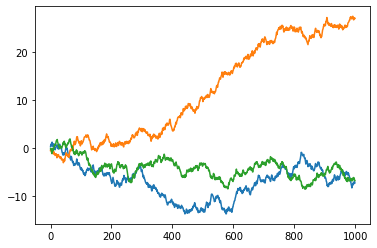

[(array([[ 0.37260959,  0.837867  ,  0.51731362,  0.98670284,  1.0468292 ],
       [-0.47209958, -0.45580347, -0.04455049, -0.24205716, -0.61402209]]), -1.0610134171484162), (array([[ 1.31315432,  0.96357684,  0.53975885,  0.43077976,  0.8115898 ],
       [-0.93827411, -0.46870424, -0.95325489, -1.04635624, -1.15367389]]), -0.45879094031869005), (array([[ 0.57455283,  0.97647956,  0.69805447,  0.23819889,  0.15159826],
       [-0.83008121, -0.67913736, -1.10992466, -1.13804105, -1.23751932]]), 0.636017765707389), (array([[-0.27746804,  0.02843711,  0.0771581 ,  0.23344052,  0.69422328],
       [-1.47535094, -1.40509507, -1.10828479, -1.39736563, -1.18660208]]), 1.6211961676756086), (array([[ 0.67308319,  0.69076937,  0.75283163,  0.45485997,  0.0225123 ],
       [-1.46257399, -1.93893486, -1.73275747, -1.43081056, -1.47427056]]), 1.2151819979065297), (array([[-0.07048988, -0.12948085,  0.32329457,  0.73683028,  0.73453525],
       [-1.30797484, -1.27908297, -1.67997286, -1.65276463, -1

In [ ]:
n_vars = 3

t = (np.random.rand(1000, n_vars) - .5).cumsum(0)
print(t.shape)
plt.plot(t)
plt.show()
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=[0,1], get_y=2)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

In [ ]:
wl = 5
n_vars = 3

t = (np.random.rand(100, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, horizon=0, get_x=columns[:-1], get_y='target')(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

(100, 3)


,var_0,var_1,target
0,0.450940,-0.079363,0.048017
1,0.565227,-0.531070,0.396526
2,0.522570,-0.168394,-0.007147
3,0.687103,-0.383624,-0.421329
4,0.227753,-0.407378,-0.612325
...,...,...,...
95,5.121781,-0.799442,-2.942670
96,4.651383,-0.539178,-3.004295
97,4.601473,-0.486023,-3.379333
98,4.622005,-0.916231,-3.149263


[(array([[ 0.45093954,  0.56522721,  0.52256993,  0.6871029 ,  0.22775284],
       [-0.07936342, -0.53107008, -0.16839444, -0.38362401, -0.40737833]]), -0.6123250394182402), (array([[ 0.56522721,  0.52256993,  0.6871029 ,  0.22775284,  0.02982811],
       [-0.53107008, -0.16839444, -0.38362401, -0.40737833, -0.55089894]]), -0.7972566368623125), (array([[ 0.52256993,  0.6871029 ,  0.22775284,  0.02982811, -0.24221765],
       [-0.16839444, -0.38362401, -0.40737833, -0.55089894, -0.70311528]]), -0.5504236118656242), (array([[ 0.6871029 ,  0.22775284,  0.02982811, -0.24221765, -0.12556322],
       [-0.38362401, -0.40737833, -0.55089894, -0.70311528, -0.25393438]]), -0.4994975091311765), (array([[ 0.22775284,  0.02982811, -0.24221765, -0.12556322,  0.06174746],
       [-0.40737833, -0.55089894, -0.70311528, -0.25393438, -0.67202147]]), -0.08860360735659378), (array([[ 0.02982811, -0.24221765, -0.12556322,  0.06174746,  0.08199054],
       [-0.55089894, -0.70311528, -0.25393438, -0.67202147

In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

(100, 5)


,var_0,var_1,var_2,var_3,target
0,-0.457024,0.260131,0.376726,0.315398,-0.181542
1,-0.881217,0.622510,0.026848,0.346502,-0.321103
2,-1.066345,0.634793,-0.432956,-0.005597,0.143361
3,-1.309965,0.649062,-0.099378,-0.196240,0.381161
4,-1.008075,0.948012,0.077149,-0.478900,-0.100931
...,...,...,...,...,...
95,1.966447,0.658435,1.323134,2.429247,-3.346599
96,1.621995,1.001670,1.565957,2.682984,-3.313887
97,1.428081,0.594941,1.192556,2.425054,-3.173126
98,1.504971,0.267231,1.602113,2.440307,-3.185286


[(array([[-0.45702387, -0.8812171 , -1.06634466, -1.30996493, -1.00807496],
       [ 0.26013056,  0.62251027,  0.63479316,  0.64906217,  0.94801167],
       [ 0.37672584,  0.02684818, -0.43295627, -0.09937805,  0.07714853],
       [ 0.31539801,  0.34650237, -0.00559674, -0.19624013, -0.47889999]]), -0.10093073254185703), (array([[-0.8812171 , -1.06634466, -1.30996493, -1.00807496, -0.62353694],
       [ 0.62251027,  0.63479316,  0.64906217,  0.94801167,  0.70023757],
       [ 0.02684818, -0.43295627, -0.09937805,  0.07714853,  0.25369689],
       [ 0.34650237, -0.00559674, -0.19624013, -0.47889999, -0.25468658]]), -0.0885995422592546), (array([[-1.06634466, -1.30996493, -1.00807496, -0.62353694, -0.92511232],
       [ 0.63479316,  0.64906217,  0.94801167,  0.70023757,  1.07405838],
       [-0.43295627, -0.09937805,  0.07714853,  0.25369689,  0.74063379],
       [-0.00559674, -0.19624013, -0.47889999, -0.25468658, -0.62969819]]), 0.3989613828913807), (array([[-1.30996493, -1.00807496, -

In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
var_0,0.179711,0.578744,0.796693,0.320477,0.192614,0.273881,-0.091231,0.096489,0.128674,-0.065056,...,-4.114216,-4.577579,-4.928586,-5.071857,-5.108447,-5.190610,-5.679092,-5.959187,-6.415132,-5.957932
var_1,-0.237522,0.117444,-0.283863,-0.275400,0.030556,0.487678,0.277272,-0.148653,0.177882,-0.181913,...,1.618087,2.034389,2.267174,2.503338,2.512144,2.774796,3.195900,3.001272,2.908509,3.241066
var_2,-0.315069,-0.592266,-0.682319,-0.325183,-0.597872,-0.313120,-0.216896,-0.495109,-0.079914,0.016719,...,-0.418831,-0.907780,-0.679829,-0.551442,-0.137118,0.140876,-0.346529,0.019336,-0.477779,-0.192954
var_3,-0.369673,-0.451059,-0.664551,-0.735336,-1.042069,-0.906921,-0.718636,-1.045171,-1.266443,-1.400775,...,-2.034609,-1.630308,-1.704264,-1.825942,-1.631296,-1.184910,-1.652691,-1.329222,-1.370406,-1.199968
target,-0.230271,-0.159757,-0.387333,-0.394828,-0.402125,-0.759011,-0.646134,-1.049000,-0.725431,-0.722680,...,-1.054961,-1.136360,-0.645204,-0.725390,-0.427184,-0.675811,-0.633820,-0.569744,-0.226827,-0.257044


[(array([[ 0.17971132,  0.57874431,  0.79669322,  0.3204774 ,  0.19261395],
       [-0.2375219 ,  0.11744356, -0.28386343, -0.27540049,  0.03055594],
       [-0.3150687 , -0.59226572, -0.68231936, -0.32518325, -0.59787174],
       [-0.36967257, -0.45105946, -0.66455082, -0.7353359 , -1.04206939]]), -0.40212495446422836), (array([[ 0.57874431,  0.79669322,  0.3204774 ,  0.19261395,  0.27388113],
       [ 0.11744356, -0.28386343, -0.27540049,  0.03055594,  0.48767776],
       [-0.59226572, -0.68231936, -0.32518325, -0.59787174, -0.31312008],
       [-0.45105946, -0.66455082, -0.7353359 , -1.04206939, -0.90692086]]), -0.7590105232268873), (array([[ 0.79669322,  0.3204774 ,  0.19261395,  0.27388113, -0.09123105],
       [-0.28386343, -0.27540049,  0.03055594,  0.48767776,  0.27727164],
       [-0.68231936, -0.32518325, -0.59787174, -0.31312008, -0.21689579],
       [-0.66455082, -0.7353359 , -1.04206939, -0.90692086, -0.71863558]]), -0.6461341936547856), (array([[ 0.3204774 ,  0.19261395, 

       [-1.18491018, -1.65269108, -1.32922198, -1.37040595, -1.19996761]]), -0.25704388133721423)]


In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
var_0,-0.343548,-0.754765,-0.990946,-1.330506,-1.412025,-1.557422,-1.962530,-1.974792,-2.435231,-1.966618,...,-1.146415,-0.760690,-1.010391,-0.905960,-0.540040,-0.400541,-0.068145,0.206179,0.173962,0.550026
var_1,0.163559,-0.042791,0.394476,-0.008583,0.128578,0.230359,-0.192737,-0.159447,0.218067,0.692361,...,-0.016595,-0.233715,-0.061918,-0.120639,0.177181,0.470482,-0.009560,0.444515,0.835720,1.314142
var_2,0.488855,0.831578,0.831415,1.321958,1.559043,1.209686,1.064485,0.971634,1.405403,1.741849,...,4.693412,4.672345,4.826271,4.658941,4.350230,4.142374,3.662338,3.821133,3.402420,2.989725
var_3,0.163761,0.609859,1.008952,0.557750,0.289636,0.581143,0.117276,0.146402,-0.334004,-0.106966,...,-0.810066,-0.507501,-0.259201,-0.652621,-1.064247,-0.790305,-0.775600,-0.456453,-0.049381,0.319582
target,0.355675,0.774796,1.060826,0.635440,0.528663,0.621930,0.603941,0.953005,0.968425,1.250766,...,1.757453,1.441932,1.236830,0.938502,1.061722,0.800560,1.201657,1.699309,1.693872,1.671725


[(array([[-0.34354848, -0.75476456, -0.99094598, -1.33050602, -1.41202511],
       [ 0.16355906, -0.042791  ,  0.39447564, -0.00858334,  0.12857801],
       [ 0.48885544,  0.83157785,  0.83141529,  1.32195817,  1.55904275],
       [ 0.16376108,  0.60985929,  1.00895165,  0.55774989,  0.28963611]]), 0.5286631225577965), (array([[-1.55742186, -1.96253007, -1.97479218, -2.43523086, -1.96661814],
       [ 0.23035938, -0.19273734, -0.15944697,  0.21806681,  0.69236128],
       [ 1.2096861 ,  1.06448549,  0.97163411,  1.40540302,  1.74184867],
       [ 0.58114313,  0.11727605,  0.14640152, -0.33400436, -0.10696596]]), 1.2507660291470657), (array([[-1.89957568, -1.97830453, -2.24612054, -2.05179511, -2.10237234],
       [ 0.79614964,  0.7302139 ,  0.82274573,  0.96843145,  0.61991805],
       [ 1.97471643,  2.02888612,  1.81287209,  2.14053233,  1.77181774],
       [-0.22525866,  0.10437429,  0.42964644,  0.779213  ,  0.58849785]]), 1.6585670181632466), (array([[-1.7189568 , -1.84973452, -1.5

In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
splits = TrainValidTestSplitter(valid_size=.2, shuffle=False)(y)
X.shape, y.shape, splits

(100, 5)


,var_0,var_1,var_2,var_3,target
0,-0.014859,0.417285,-0.056309,-0.242727,0.166490
1,0.243699,0.834754,0.177594,-0.273107,-0.053451
2,0.395490,1.111600,0.466471,-0.184783,0.206307
3,0.115607,1.319305,0.090760,-0.320072,0.518329
4,-0.182939,1.168774,0.402266,-0.740028,0.131642
...,...,...,...,...,...
95,1.911218,6.747716,5.645412,-6.009719,-1.049908
96,2.246228,6.328891,5.327188,-6.063094,-1.052925
97,2.296534,6.342581,5.067742,-6.317340,-0.867247
98,2.144480,6.435208,4.672590,-6.524465,-0.980075


((96, 4, 5),
 (96,),
 (#2) [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76],[77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95]])

In [ ]:
#hide
out = create_scripts()
beep(out)